In [1]:
%matplotlib inline

# Import Dependencies

In [2]:
# System & OS
import warnings
warnings.filterwarnings('ignore')

# Data Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('whitegrid')      # background
plt.rc('figure', titlesize=24)  # figure title 
plt.rc('axes', titlesize=18)    # axes title
plt.rc('axes', labelsize=18)    # xy labels
plt.rc('xtick', labelsize=14)   # x tick labels
plt.rc('ytick', labelsize=14)   # y tick labels
plt.rc('legend', fontsize=14)   # legend

# Utility Functions
from utils import *

# Miscellaneous
from decimal import Decimal
from tqdm.notebook import tqdm

# Mount Storage

To start, `cd` to where the data are stored.

In [3]:
%cd '../data/'

/Users/zach/Documents/Projects/Protostellar-Luminosity/data


# Feature Engineering

Then, read in our previous results from `master_file.csv`.

In [4]:
df = pd.read_csv('master_file.csv', skiprows=1, names=['Model number',
                                                       'Class', 
                                                       'Mass ratio', 
                                                       'Timestep', 
                                                       'Inclination', 
                                                       'Wavelength (cm)', 
                                                       'Flux (erg cm^-2 s^-1)', 
                                                       'L_int (Lsun)'])
df

,Model number,Class,Mass ratio,Timestep,Inclination,Wavelength (cm),Flux (erg cm^-2 s^-1),L_int (Lsun)
0,1,0,0.034096,2,5,3.600030,1.171193e-18,0.001486
1,1,0,0.034096,2,5,2.400020,4.342741e-18,0.001486
2,1,0,0.034096,2,5,1.600013,1.734933e-17,0.001486
3,1,0,0.034096,2,5,1.300011,3.665945e-17,0.001486
4,1,0,0.034096,2,5,1.100009,6.839343e-17,0.001486
...,...,...,...,...,...,...,...,...
8993595,33,1,0.885142,379,85,0.000025,2.878049e-13,5.9644
8993596,33,1,0.885142,379,85,0.000020,1.755736e-14,5.9644
8993597,33,1,0.885142,379,85,0.000015,-1.782472e-16,5.9644
8993598,33,1,0.885142,379,85,0.000010,-1.308467e-17,5.9644


Next, perform the following feature modifications:

1. Drop the timestep and inclination columns.
2. Typecast mass ratio and luminosity columns to `float`.
3. Convert wavelengths from cm to microns. $$\begin{align*}\lambda=\lambda_0\times10^4\end{align*}$$ where $\lambda_0$ denotes the initial wavelength (in cm), and $\lambda$ the corrected wavelength (in microns).
4. Further subdivide class 1 into 1a and 1b. $$\begin{align*}\text{class}=\begin{cases}0,&M<0.5\\1\text{a},&0.5\leq M<0.75\\1\text{b},&M\geq 0.75\end{cases}\end{align*}$$ where $M$ denotes the internal vs final mass ratio.
5. Compute the logged (`log10`) flux and internal luminosities. $$\begin{align*}\begin{split}F&=\log_{10}{\left(F_0\right)}\\L&=\log_{10}{\left(L_0\right)}\end{split}\end{align*}$$where $F_0$ and $F$ represent the flux values in linear and `log10` space, respectively (and equivalently for $L_0$ and $L$).
6. Drop rows with internal luminosity $L<0.1$.

In [5]:
# Drop irrelevant columns
df.drop(columns=['Timestep', 'Inclination'], inplace=True)

# Typecast objects to float64
df['Mass ratio'] = df['Mass ratio'].apply(lambda x: float(x))
df['L_int (Lsun)'] = df['L_int (Lsun)'].apply(lambda x: float(x))

# Convert wavelengths to microns
df['Wavelength (cm)'] = df['Wavelength (cm)'].apply(lambda x: x * 10000.0)
df.rename(columns={'Wavelength (cm)': 'Wavelength (microns)'}, inplace=True)

# Subdivide class 1 into 1a and 1b
df.loc[df['Mass ratio'] < 0.5, 'Class'] = '0'
df.loc[(df['Mass ratio'] >= 0.5) & (df['Mass ratio'] < 0.75), 'Class'] = '1a'
df.loc[df['Mass ratio'] >= 0.75, 'Class'] = '1b'

# Add columns with logged data
df['log(Flux)'] = np.log10(df['Flux (erg cm^-2 s^-1)'].values)
df['log(L_int)'] = np.log10(df['L_int (Lsun)'].values)

# Drop rows with L_int < 0.1
df = df[df['L_int (Lsun)'] >= 0.1]

# Print number of rows dropped from original dataframe
print(f'Number of rows dropped: {8993600 - len(df)} ({(8993600 - len(df)) / 8993600 * 100:.2f}%)')

Number of rows dropped: 1097100 (12.20%)


# Handle Missing Values

Since non-positive flux values are undefined in `log10` space, there are now rows with infinities that we must deal with accordingly.

In [6]:
# Replace Inf values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Print percentage of missing values
check_nan(df)

Percentage of missing values in each column:

log(Flux)                1.78
Model number             0.00
Class                    0.00
Mass ratio               0.00
Wavelength (microns)     0.00
Flux (erg cm^-2 s^-1)    0.00
L_int (Lsun)             0.00
log(L_int)               0.00
dtype: float64



Notice, there are relatively few missing values w.r.t. the full population. Hence, we opt to simply drop the rows containing `NaN` values.

In [7]:
# Drop missing values
df.dropna(axis=0, inplace=True)

# Print number of rows dropped from original dataframe
print(f'Number of rows dropped: {7896500 - len(df)} ({(7896500 - len(df)) / 8993600 * 100:.2f}%)')

Number of rows dropped: 140301 (1.56%)


# Data Analysis

Finally, we execute the following analysis steps:

1. Visualize (linear) flux as a function of (linear) luminosity in `log10` space.
2. Fit a linear regression model to the logged data.
3. Extract the associated linear coefficients (i.e. slope, intercept, and corresponding uncertainties).
4. Compute the 1 $\sigma$ standard deviation of model variance $V$, defined as $$\begin{split}V&=\log_{10}\left(L_\text{pred}\right)-\log_{10}(L)\\&=\log_{10}\left(\frac{L_\text{pred}}{L}\right)\end{split}$$ where $L_\text{pred}$ denotes the predicted luminosity, and $L$ the actual luminosity.
5. Evaluate the goodness-of-fit (in both linear and `log10` space) via reduced-chi squared. $$\begin{align*}\chi_\nu^2=\frac{\chi^2}{\nu}\end{align*}$$ where $\chi$ represents a weighted sum of squared deviations, and $\nu$ the degree(s) of freedom. Further reading available [here](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic).
6. Calculate the correlation coefficients (in both linear and `log10` space) between flux and luminosity. $$\begin{align*}r=\frac{\sum_i(L_i-\bar{L})(F_i-\bar{F})}{\sqrt{\sum_i(L_i-\bar{L})^2\sum_i(F_i-\bar{F})^2}}\end{align*}$$ where $\bar{L}$ and $\bar{F}$ denote the mean luminosity and flux values, respectively. Further reading available [here](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

Below is an example using the data at ~70 microns.

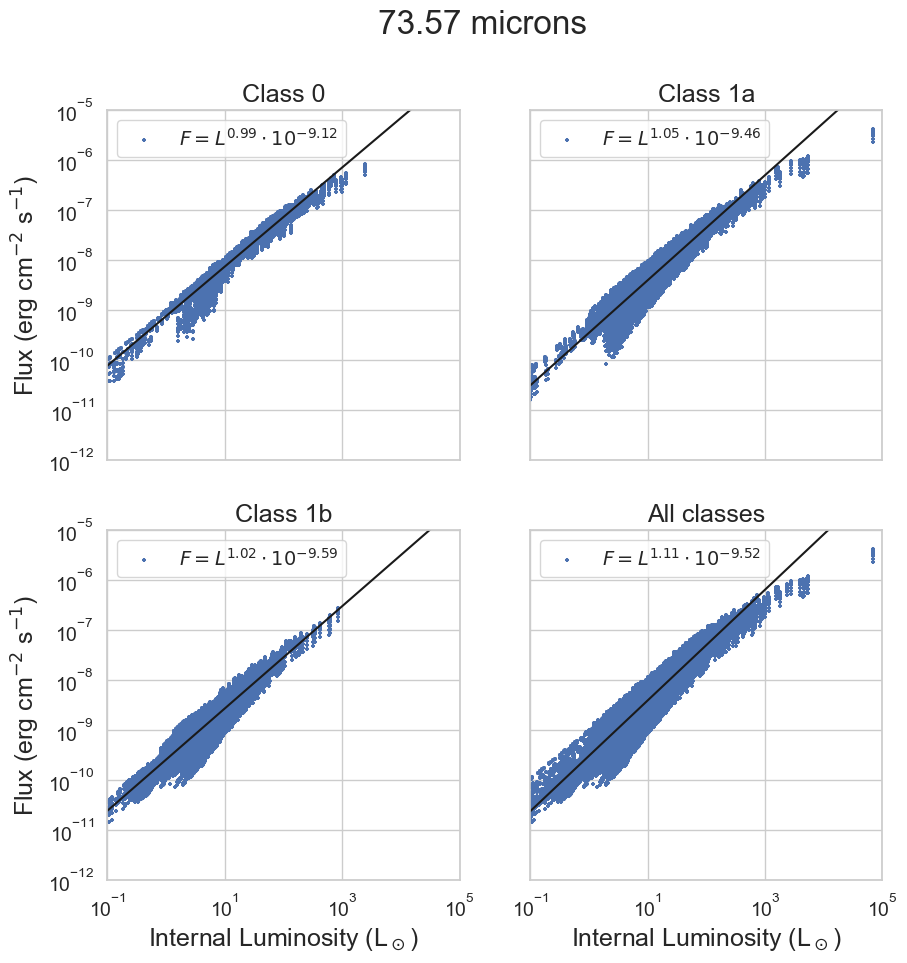

In [8]:
# Retrive the data closest to 70 microns
df_wavelength = df[np.isclose(df['Wavelength (microns)'], 7.35706025e+01)]
# Create a 4-figure subplot, where each subplot represents a unique class
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
# Customize plot
fig.suptitle(f'{Decimal(7.35706025e+01):.2f} microns')
# Customize axes
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_xlim([1e-1, 1e5])
ax[0, 0].set_ylim([1e-12, 1e-5])
ax[0, 0].set_ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
ax[1, 0].set_ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
ax[1, 0].set_xlabel('Internal Luminosity (L$_\odot$)')
ax[1, 1].set_xlabel('Internal Luminosity (L$_\odot$)')
# Map class to subplot position
class_map = {'0': (0, 0), 
             '1a': (0, 1), 
             '1b': (1, 0), 
             'All': (1, 1)}
for class_name in class_map:
    # Partition data based on class
    if class_name == 'All':
        x, y = df_wavelength['L_int (Lsun)'], df_wavelength['Flux (erg cm^-2 s^-1)']
        log_x, log_y = df_wavelength['log(L_int)'], df_wavelength['log(Flux)']
    else:
        x, y = df_wavelength[df_wavelength['Class'] == class_name]['L_int (Lsun)'], df_wavelength[df_wavelength['Class'] == class_name]['Flux (erg cm^-2 s^-1)']
        log_x, log_y = df_wavelength[df_wavelength['Class'] == class_name]['log(L_int)'], df_wavelength[df_wavelength['Class'] == class_name]['log(Flux)']
    # Compute relevant metrics
    m, unc_m, b, unc_b = lin_reg(log_x, log_y)
    model_variance = model_var(x, y, m, b)
    lin_rcs, log_rcs = chi_sq(x, y, log_x, log_y, m, b)
    lin_corr, log_corr = corr_coef(x, y, log_x, log_y)
    # Make plots
    row, col = class_map[class_name]
    ax[row, col].scatter(x, y, marker='+', s=6, label='__nolegend__')
    if class_name == 'All':
        ax[row, col].set_title('All classes')
    else:
        ax[row, col].set_title(f'Class {class_name}')
    # Visualize linear regression
    X = np.linspace(1e-1, 1e5)
    Y = X**m * 10**b
    ax[row, col].plot(X, Y, c='k')
    # Add legend
    ax[row][col].legend([f'$F = L^{{{m:.2f}}} \cdot 10^{{{b:.2f}}}$'], loc='best')
    # Save figure
    plt.savefig(f'../src/images/flux_vs_lint_{Decimal(7.35706025e+01):.2e}.jpg', format='jpg')
# Display final result
plt.show()

We reserve discussion regarding the above plot/results for the next notebook (`3_compare_classes.ipynb`). For now, repeat the aforementioned steps for each of the 100 wavelengths where data are available. Note the use of the utility function `make_plot()`, defined in `utils.py`.

In [9]:
# Write column headers for lin_coef.csv, corr_coef.csv, and model_var.csv
with open('lin_coef.csv', 'w') as coef, open('corr_coef.csv', 'w') as corr, open('model_var.csv', 'w') as var:
  coef.write('Class, Wavelength (microns), Slope, Unc_slope, Intercept, Unc_intercept\n')
  corr.write('Class, Wavelength (microns), Reduced chi-squared (linear space), Reduced chi-squared (log10 space), Correlation coefficient (linear space), Correlation coefficient (log10 space)\n')
  var.write('Class, Wavelength (microns), Std. Dev. of Model Variance\n')
coef.close()
corr.close()
var.close()

In [10]:
# Initialize progress bar
with tqdm(total=df['Wavelength (microns)'].nunique()) as pbar:
    # Partition data based on wavelength
    for wavelength in df['Wavelength (microns)'].unique():
        df_wavelength = df[np.isclose(df['Wavelength (microns)'], wavelength)]
        # For each wavelength, create a 4-figure subplot, where each subplot represents a unique class
        fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
        # Make subplots
        make_plot(df_wavelength, wavelength, fig, ax)
        # Save figure
        plt.savefig(f'Figures/flux_vs_lint_{Decimal(wavelength):.2e}.eps', format='eps', dpi=1200)
        # Clear figure
        plt.clf()
        # Update progress bar
        pbar.update(1)

  0%|          | 0/100 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Finally, create an additional master plot containing data at all wavelengths.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


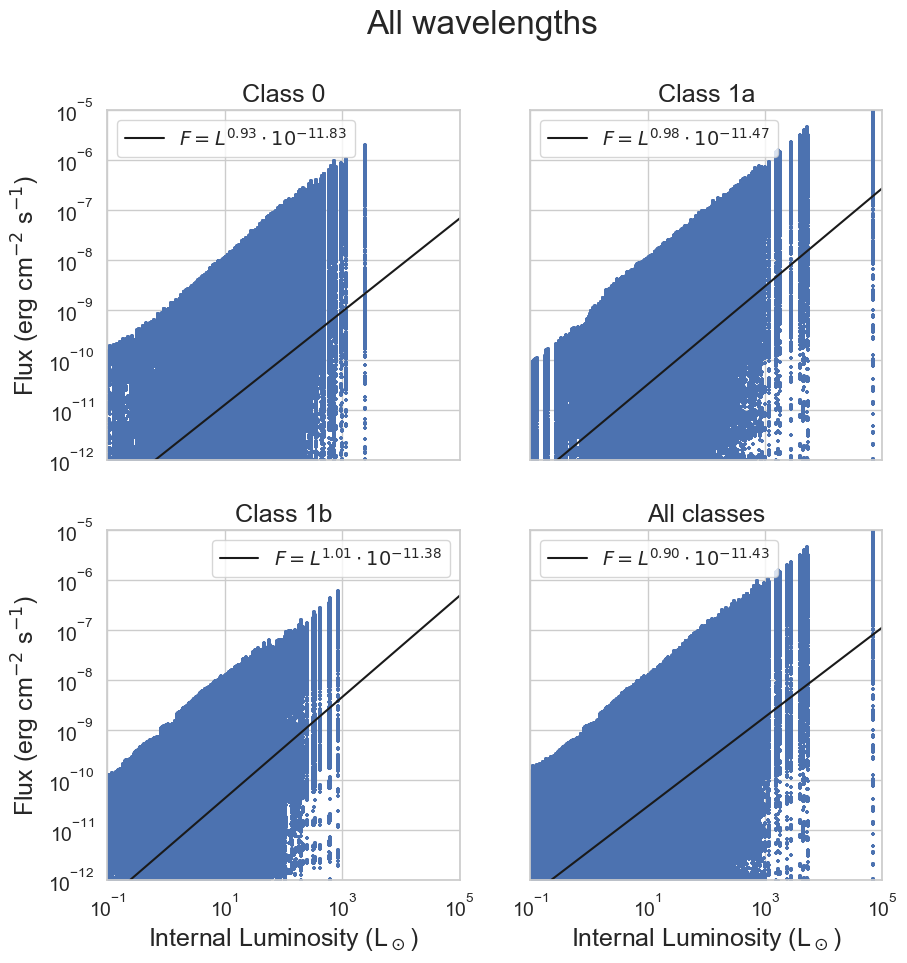

In [11]:
# Create master plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
# Make subplots
make_plot(df, 'All', fig, ax)
# Save figure
plt.savefig('Figures/flux_vs_lint_master.eps', format='eps', dpi=1200)
plt.savefig('../src/images/flux_vs_lint_master.jpg', format='jpg')
# Show figure
plt.show()